<h1><center><b><font color='brown'>Gesture Recognition</font></b></center></h1>

<h3><b>Problem Statement</b></h3>


As a data scientist for home electronics company, we want to develop a cool feature for smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command/action described below:

*   Thumbs up:  Increase the volume
*   Thumbs down: Decrease the volume
*   Left swipe: 'Jump' backwards 10 seconds
*   Right swipe: 'Jump' forward 10 seconds
*   Stop: Pause the movie


<h4><b><font color='brown'>Importing libraries</b></font></h4>

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt

In [2]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

print(tf.__version__)

2.12.0


In [3]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.optimizers.legacy import Adam

<h4><b><font color='brown'>Linking Dataset</b></font></h4>

In [5]:
# mounting google drive to import dataset (data kept on drive and using colab to utilize GPUs for faster results)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
data_dir = '/content/gdrive/MyDrive/UpGrad Neural Network/RNN Gesture Recognition'

In [7]:
train_doc = np.random.permutation(open(data_dir + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_dir + '/val.csv').readlines())

batch_size = 32

<h4><b><font color='brown'>Generator Custom Function</b></font></h4>

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(30) if x%2!=0]    #create a list of image numbers you want to use for a particular videoz
    y=120
    z=120
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size   # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image_resized = resize(image,(120,120)).astype('float32')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255  #normalise and feed in the image

                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if len(folder_list) > num_batches * batch_size:
          leftovers = len(folder_list) - (num_batches * batch_size)
          batch_data = np.zeros((leftovers,len(img_idx),y,z,3))
          batch_labels = np.zeros((leftovers,5))
          
          for folder in range(leftovers):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image_resized = resize(image,(120,120)).astype('float32')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = data_dir + '/train'
val_path = data_dir + '/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


<h4><b><font color='brown'>Graph Plotter</b></font></h4>

In [10]:
def viz(history):
          
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

<h4><b><font color='brown'>Model 1 : Convolution 3D Model</b></font></h4>

Here you make the first 3d Convolution model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model

In [11]:
model_cnn3d = Sequential()

model_cnn3d.add(Conv3D(16, kernel_size=(3,3,3), padding='same', input_shape=(15,120,120,3), activation='relu'))
model_cnn3d.add(BatchNormalization())
model_cnn3d.add(MaxPooling3D(pool_size=(2,2,2))) #, strides = (2,2,2)))

model_cnn3d.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model_cnn3d.add(BatchNormalization())
model_cnn3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_cnn3d.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model_cnn3d.add(BatchNormalization())
model_cnn3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_cnn3d.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model_cnn3d.add(BatchNormalization())
# model_cnn3d.add(MaxPooling3D(pool_size=(2,2,2)))

# model_cnn3d.add(Conv3D(256, kernel_size=(3,3,3), padding='same', activation='relu'))
# model_cnn3d.add(BatchNormalization())

model_cnn3d.add(Flatten())

model_cnn3d.add(Dense(128,activation='relu'))
model_cnn3d.add(Dropout(0.5))

model_cnn3d.add(Dense(64,activation='relu'))
model_cnn3d.add(Dropout(0.5))

# softmax layer for 5 gesture actions
model_cnn3d.add(Dense(5,activation='softmax'))


In [12]:
optimiser = Adam()
model_cnn3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn3d.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 32)    128       
 hNormalization)                                                 
                                                        

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)   # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
history_cnn3d = model_cnn3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                     verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/UpGrad Neural Network/RNN Gesture Recognition/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 3.2212 - categorical_accuracy: 0.2745  Source path =  /content/gdrive/MyDrive/UpGrad Neural Network/RNN Gesture Recognition/val ; batch size = 32

Epoch 1: saving model to model_init_2023-05-2207_47_51.020455/model-00001-3.22123-0.27451-1.56159-0.25000.h5
21/21 [==============================] - 2795s 139s/step - loss: 3.2212 - categorical_accuracy: 0.2745 - val_loss: 1.5616 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.7473 - categorical_accuracy: 0.2911
Epoch 2: saving model to model_init_2023-05-2207_47_51.020455/model-00002-1.74729-0.29110-1.74172-0.17000.h5
21/21 [==============================] - 124s 6s/step - loss: 1.7473 - categorical_accuracy: 0.2911 - val_loss: 1.7417 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
21/2

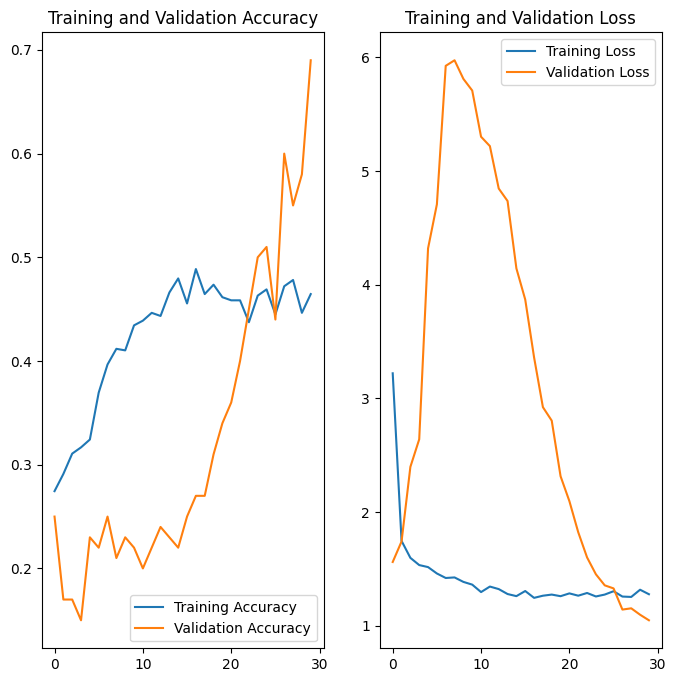

In [17]:
# accuracy & loss graphs for CNN-3D model
viz(history_cnn3d)

<h4><b><font color='brown'>Model 2 (CNN + RNN) : Conv-2D + LSTM</b></font></h4>

In [18]:
model_2dlstm = Sequential()

model_2dlstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(15,120,120,3)))
model_2dlstm.add(TimeDistributed(BatchNormalization()))
model_2dlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dlstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_2dlstm.add(TimeDistributed(BatchNormalization()))
model_2dlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dlstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_2dlstm.add(TimeDistributed(BatchNormalization()))
model_2dlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dlstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_2dlstm.add(TimeDistributed(BatchNormalization()))
model_2dlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# model_2dlstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model_2dlstm.add(TimeDistributed(BatchNormalization()))
# model_2dlstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dlstm.add(TimeDistributed(Flatten()))


model_2dlstm.add(LSTM(64))
model_2dlstm.add(Dropout(0.5))

# model_2dlstm.add(Dense(128,activation='relu'))
# model_2dlstm.add(Dropout(0.5))
model_2dlstm.add(Dense(64,activation='relu'))
model_2dlstm.add(Dropout(0.5))

model_2dlstm.add(Dense(5, activation='softmax'))



In [19]:
optimiser = Adam()
model_2dlstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2dlstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 60, 60, 32)  

In [20]:
history_2dlstm = model_2dlstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                            verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6668 - categorical_accuracy: 0.2519
Epoch 1: saving model to model_init_2023-05-2207_47_51.020455/model-00001-1.66678-0.25189-1.73924-0.20000.h5
21/21 [==============================] - 130s 6s/step - loss: 1.6668 - categorical_accuracy: 0.2519 - val_loss: 1.7392 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5485 - categorical_accuracy: 0.2911
Epoch 2: saving model to model_init_2023-05-2207_47_51.020455/model-00002-1.54852-0.29110-1.85575-0.17000.h5
21/21 [==============================] - 121s 6s/step - loss: 1.5485 - categorical_accuracy: 0.2911 - val_loss: 1.8557 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4872 - categorical_accuracy: 0.3409
Epoch 3: saving model to model_init_2023-05-2207_47_51.020455/model-00003-1.48715-0.34087-1.80858-0.18000.h5
21/21 [==============

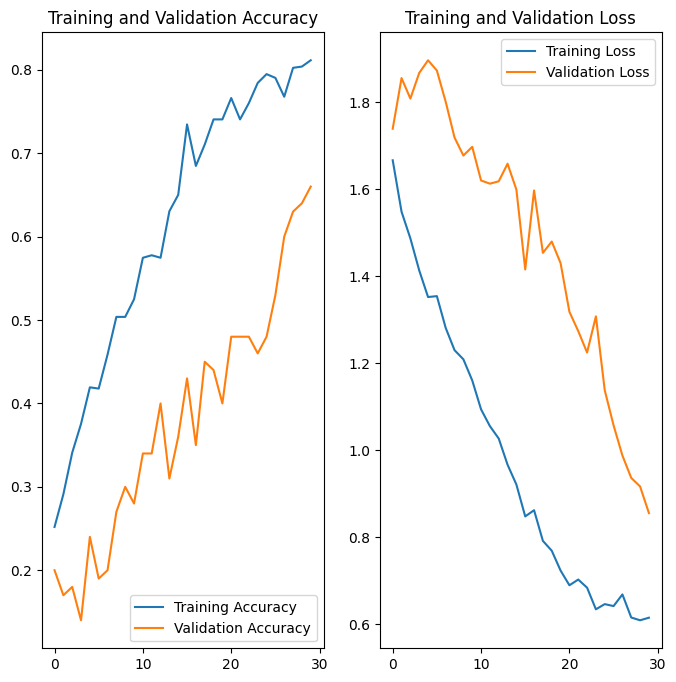

In [21]:
# accuracy & loss graphs for LSTM model
viz(history_2dlstm)

<h4><b><font color='brown'>Model 3 (CNN + RNN) : Conv-2D + GRU</b></font></h4>

In [22]:
#Conv2D+GRU
model_2dgru = Sequential()

model_2dgru.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(15,120,120,3)))
model_2dgru.add(TimeDistributed(BatchNormalization()))
model_2dgru.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dgru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_2dgru.add(TimeDistributed(BatchNormalization()))
model_2dgru.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dgru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_2dgru.add(TimeDistributed(BatchNormalization()))
model_2dgru.add(TimeDistributed(MaxPooling2D((2, 2))))

model_2dgru.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_2dgru.add(TimeDistributed(BatchNormalization()))
model_2dgru.add(TimeDistributed(MaxPooling2D((2, 2))))


model_2dgru.add(TimeDistributed(Flatten()))

model_2dgru.add(GRU(128))
model_2dgru.add(Dropout(0.25))

model_2dgru.add(Dense(128,activation='relu'))
model_2dgru.add(Dropout(0.5))
model_2dgru.add(Dense(64,activation='relu'))
model_2dgru.add(Dropout(0.5))

model_2dgru.add(Dense(5, activation='softmax'))



In [23]:
optimiser = Adam()
model_2dgru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2dgru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 60, 60, 32)  

In [24]:
history_2dgru = model_2dgru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                          verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7557 - categorical_accuracy: 0.2338
Epoch 1: saving model to model_init_2023-05-2207_47_51.020455/model-00001-1.75571-0.23379-1.68486-0.23000.h5
21/21 [==============================] - 124s 6s/step - loss: 1.7557 - categorical_accuracy: 0.2338 - val_loss: 1.6849 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5458 - categorical_accuracy: 0.3228
Epoch 2: saving model to model_init_2023-05-2207_47_51.020455/model-00002-1.54584-0.32278-1.65938-0.18000.h5
21/21 [==============================] - 118s 6s/step - loss: 1.5458 - categorical_accuracy: 0.3228 - val_loss: 1.6594 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4813 - categorical_accuracy: 0.3379
Epoch 3: saving model to model_init_2023-05-2207_47_51.020455/model-00003-1.48130-0.33786-1.71311-0.23000.h5
21/21 [==============

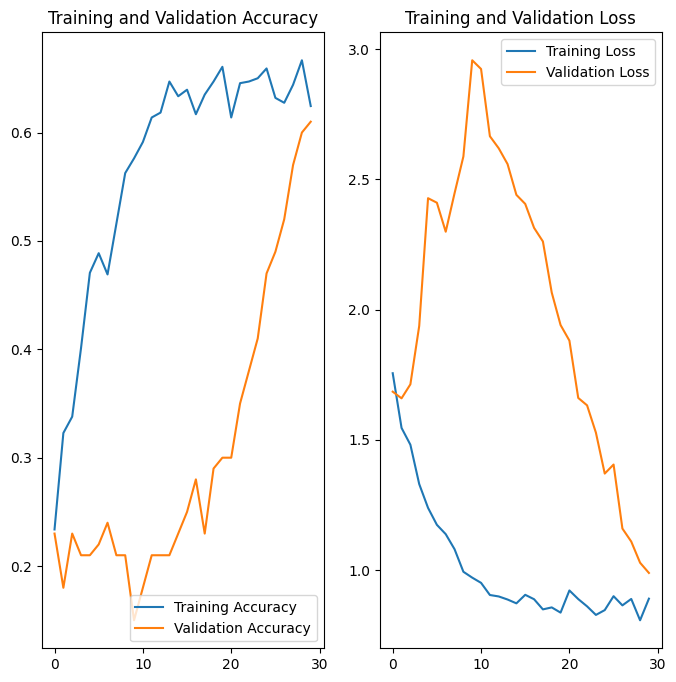

In [25]:
# accuracy & loss graphs for GRU model
viz(history_2dgru)

<h4><b><font color='brown'>Transfer Learning Mobilenet Based GRU & LSTM Models</b></font></h4>

<h4><b><font color='brown'>Model 4 : MobileNet Based LSTM</b></font></h4>

In [26]:
from keras.applications import mobilenet

In [27]:
#Instantiates the MobileNet architecture.
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [28]:
model_mnlstm = Sequential()

model_mnlstm.add(TimeDistributed(base_model,input_shape=(15,120,120,3)))

#freeze the convolutional base. Freezing prevents the weights in a given layer from being updated during training.
for layer in model_mnlstm.layers:
    layer.trainable = False

model_mnlstm.add(TimeDistributed(BatchNormalization()))
model_mnlstm.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mnlstm.add(TimeDistributed(Flatten()))

model_mnlstm.add(LSTM(64))
model_mnlstm.add(Dropout(0.25))

model_mnlstm.add(Dense(64,activation='relu'))
model_mnlstm.add(Dropout(0.25))

model_mnlstm.add(Dense(5, activation='softmax'))



In [29]:
optimiser = Adam()
model_mnlstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_mnlstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 10, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)               

In [30]:
history_mnlstm = model_mnlstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                            verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5407 - categorical_accuracy: 0.3183
Epoch 1: saving model to model_init_2023-05-2207_47_51.020455/model-00001-1.54065-0.31825-1.37005-0.54000.h5
21/21 [==============================] - 130s 6s/step - loss: 1.5407 - categorical_accuracy: 0.3183 - val_loss: 1.3701 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0906 - categorical_accuracy: 0.6365
Epoch 2: saving model to model_init_2023-05-2207_47_51.020455/model-00002-1.09059-0.63650-1.12217-0.57000.h5
21/21 [==============================] - 113s 6s/step - loss: 1.0906 - categorical_accuracy: 0.6365 - val_loss: 1.1222 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.7541 - categorical_accuracy: 0.7677
Epoch 3: saving model to model_init_2023-05-2207_47_51.020455/model-00003-0.75412-0.76772-0.81986-0.67000.h5
21/21 [==============

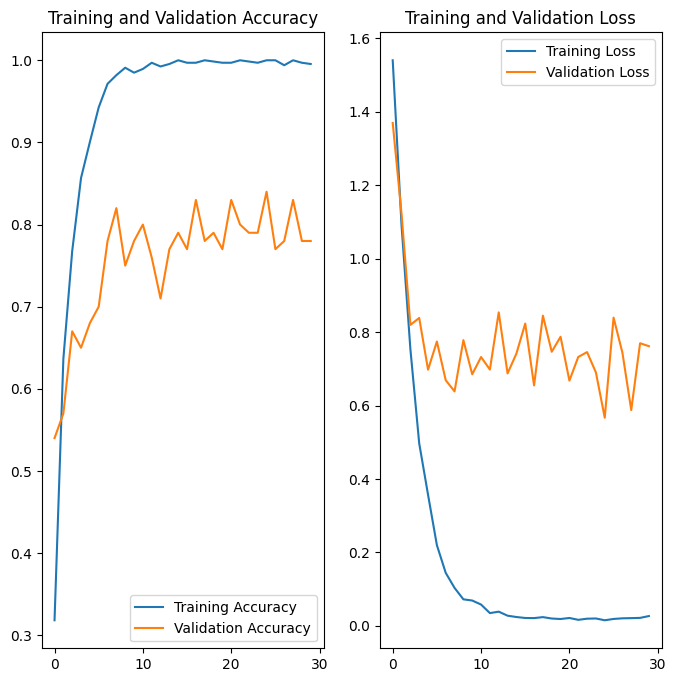

In [31]:
# accuracy & loss graphs for Mobilenet based LSTM
viz(history_mnlstm)

<h4><b><font color='brown'>Model 5 : MobileNet Based GRU</b></font></h4>

In [32]:
model_mngru = Sequential()

model_mngru.add(TimeDistributed(base_model,input_shape=(15,120,120,3)))

#freeze the convolutional base. Freezing prevents the weights in a given layer from being updated during training.
for layer in model_mngru.layers:
    layer.trainable = False

model_mngru.add(TimeDistributed(BatchNormalization()))
model_mngru.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mngru.add(TimeDistributed(Flatten()))

model_mngru.add(GRU(64))
model_mngru.add(Dropout(0.25))

model_mngru.add(Dense(64,activation='relu'))
model_mngru.add(Dropout(0.25))

model_mngru.add(Dense(5, activation='softmax'))



In [33]:
optimiser = Adam()
model_mngru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_mngru.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 10, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [34]:
history_mngru = model_mngru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                          verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5138 - categorical_accuracy: 0.3424
Epoch 1: saving model to model_init_2023-05-2207_47_51.020455/model-00001-1.51381-0.34238-1.22907-0.53000.h5
21/21 [==============================] - 123s 6s/step - loss: 1.5138 - categorical_accuracy: 0.3424 - val_loss: 1.2291 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9872 - categorical_accuracy: 0.6290
Epoch 2: saving model to model_init_2023-05-2207_47_51.020455/model-00002-0.98724-0.62896-0.90552-0.67000.h5
21/21 [==============================] - 117s 6s/step - loss: 0.9872 - categorical_accuracy: 0.6290 - val_loss: 0.9055 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6393 - categorical_accuracy: 0.8009
Epoch 3: saving model to model_init_2023-05-2207_47_51.020455/model-00003-0.63927-0.80090-0.75537-0.71000.h5
21/21 [==============

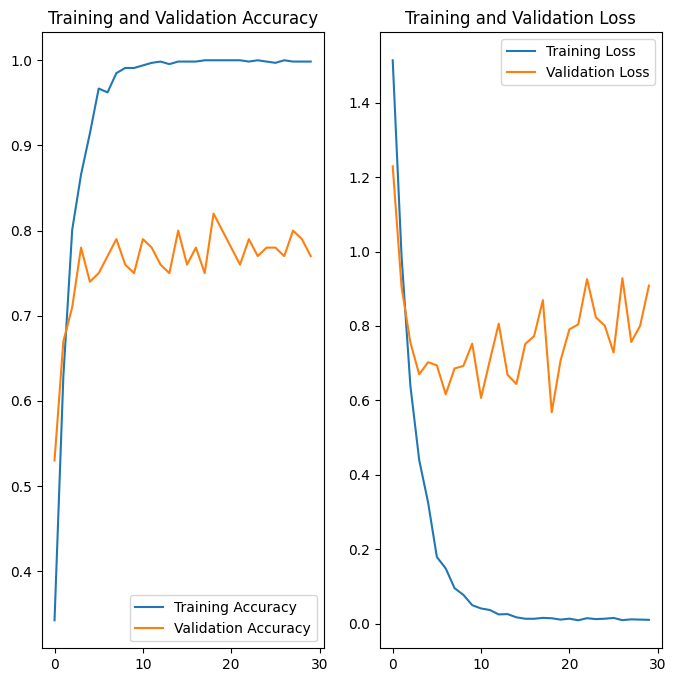

In [35]:
# accuracy & loss graphs for Mobilenet based GRU
viz(history_mngru)

<h4><b><font color='brown'>Model 6 : MobileNet Based LSTM (Experiment with Batch Size of 64)</b></font></h4>

> Since the Model 4 (MobileNet Based LSTM) has the best performance among all, we're experimenting with batch size to see whether it has any impact on overall accuracy

In [15]:
# training model 4 with batch size 64

batch_size=64
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)   # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
history_mnlstm64 = model_mnlstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                              verbose=1,callbacks=callbacks_list, validation_data=val_generator,
                                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/UpGrad Neural Network/RNN Gesture Recognition/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6305 - categorical_accuracy: 0.2353  Source path =  /content/gdrive/MyDrive/UpGrad Neural Network/RNN Gesture Recognition/val ; batch size = 64

Epoch 1: saving model to model_init_2023-05-2407_35_52.699922/model-00001-1.63047-0.23529-1.48184-0.48000.h5
11/11 [==============================] - 4047s 401s/step - loss: 1.6305 - categorical_accuracy: 0.2353 - val_loss: 1.4818 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.3224 - categorical_accuracy: 0.5098 
Epoch 2: saving model to model_init_2023-05-2407_35_52.699922/model-00002-1.32240-0.50980-1.24545-0.61000.h5
11/11 [==============================] - 317s 30s/step - loss: 1.3224 - categorical_accuracy: 0.5098 - val_loss: 1.2455 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/30
11

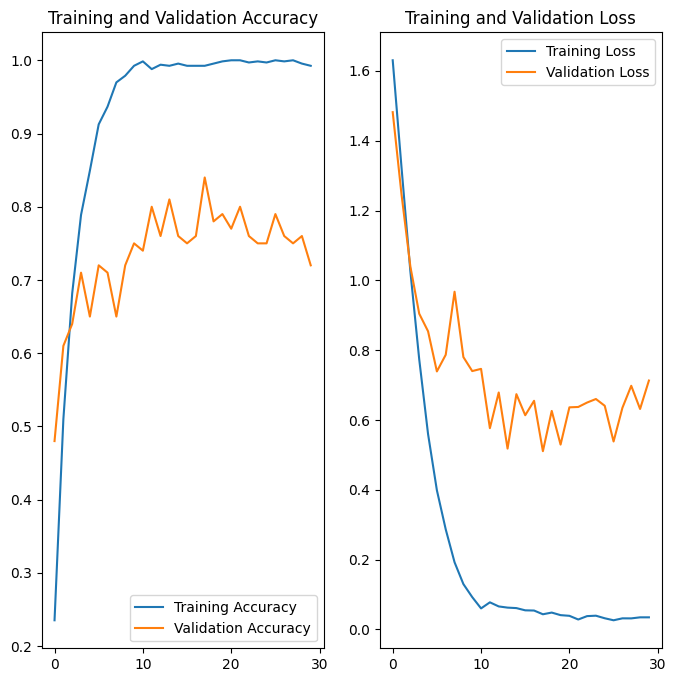

In [19]:
# accuracy & loss graphs for Mobilenet based LSTM Experiment 2
viz(history_mnlstm64)

<h3><font color='brown'>Conclusion</font></h3>


> **This MobileNet based LSTM with batch size of 64 has slight improvements over its version with batch size of 32**

> **We have the best accuracy score at epoch 18 for this model.**

        The accuracy values are below: 
        loss: 0.0433 - categorical_accuracy: 0.9925
        val_loss: 0.5105 - val_categorical_accuracy: 0.8400
